In [1]:
# some imports
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

# Python ≥3.5 is required
import sys

assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn

assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf

assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
# % matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12)
plt.rc('figure', figsize=(12, 5))

# Settings for the visualizations
#import seaborn as sns
#sns.set_style("whitegrid")
#sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

import pandas as pd

pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

# Ignore useless warnings (see SciPy issue #5998)
import warnings

warnings.filterwarnings(action="ignore", message="^internal gelsd")
# Others
import cv2
import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
import copy
from skimage.io import imread
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
import util.Display_images as display

In [2]:
import winsound


def beep():
    winsound.Beep(500, 1000)

 ## Import data

In [108]:
# tf.random.set_seed(42)
# np.random.seed(42)

In [3]:
# Paths
X_train_path = './dataset/train/train/train/'
X_test_path = './dataset/test/test/test/'
dataset_csv = './dataset/train.txt'
dataset_csv_test = './dataset/test.txt'
dataset_train_path = './dataset/train/train'
dataset_test_path = './dataset/test/test'
_STOP = 20000
checkpoint_dir = "./ckpt/cc-3-complex-r"
aug_types = [0, 1, 2]

In [4]:
def preprocess(img_props, dataset_path, preprocess_img_method):
    print("loading data")
    data = []
    for img_prop in tqdm.tqdm(img_props):
        img_path = img_prop[0]
        aug_type = img_prop[1]
        path = os.path.realpath(os.path.join(dataset_path, img_path[1:]))
        img = preprocess_img_method(path, aug_type)
        data.append(img)
    print("loading data done")
    return data


def preprocess_test(img_paths, dataset_path, preprocess_img_method):
    print("loading data")
    data = []
    for img_path in tqdm.tqdm(img_paths):
        path = os.path.realpath(os.path.join(dataset_path, img_path[1:]))
        img = preprocess_img_method(path, 0)  # no aug image for test
        data.append(img)

    print("loading data done")
    return data


def preprocess_img(path, aug_type):
    img = imread(path)
    img = img / 255.  #normalize
    img = augment_grayscale(img, aug_type)  # augment the images
    return img


def augment_grayscale(img, aug_type):
    if aug_type == 0:
        return img
    elif aug_type == 1:
        new_img = tf.image.random_flip_left_right(img[:, :, np.newaxis])
        return new_img[:, :, 0]
    elif aug_type == 2:
        new_img = tf.image.flip_up_down(img[:, :, np.newaxis])
        return new_img[:, :, 0]
    elif aug_type == 3:
        new_img = tf.image.rot90(img[:, :, np.newaxis])
        return new_img[:, :, 0]
    return img

In [5]:
df = pd.read_csv(dataset_csv, delimiter='\ ', header=None)

C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [6]:
labels = np.array(df[1])[:_STOP]
img_paths = np.array(df[0][:_STOP])

In [7]:
# Prepare data augment
img_paths_full = []
labels_full = []
for type in aug_types:
    img_paths_full.extend([(path, type) for path in img_paths])
    labels_full.extend([label for label in labels])

In [9]:
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(img_paths_full, labels_full, random_state=42,
                                                                        test_size=0.25)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, random_state=42, test_size=0.2)

In [55]:
# direct load - way faster
X_train_preloaded = preprocess(X_train_full, dataset_train_path, preprocess_img)
X_train_preloaded = np.stack(X_train_preloaded)
X_train_preloaded = X_train_preloaded.astype("float32")
y_train_full = np.array(y_train_full).astype("float32")
print(X_train_preloaded.shape)
print(y_train_full.shape)

loading data


100%|██████████| 33750/33750 [00:41<00:00, 819.68it/s]


loading data done
(33750, 158, 158)
(33750,)


In [10]:
no_classes = int(np.max(y_train_full) + 1)
print("Number of classes: ", no_classes)

Number of classes:  30


In [19]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for fitting - one batch at a time'

    def __init__(self, X_dataset, labels, dataset_path, batch_size=32, dim=(158, 158),
                 n_classes=10, categorical_labels=False, transforms=None, shuffle=True):
        'Initialization'
        self.X_dataset = copy.deepcopy(X_dataset)
        self.labels = copy.deepcopy(labels)
        self.dataset_path = dataset_path
        self.batch_size = batch_size
        self.dim = dim
        self.n_classes = n_classes
        self.categorical_labels = categorical_labels
        self.transforms = transforms
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        batches_per_epoch = int(np.floor(len(self.X_dataset) / self.batch_size))
        return batches_per_epoch

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)
        return X, y

    def __call__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)
            if i == self.__len__() - 1:
                self.on_epoch_end()

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X_dataset))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        # Find list of paths
        X_dataset_temp = [self.X_dataset[k] for k in indexes]
        # Find labels
        y = [self.labels[k] for k in indexes]
        if self.categorical_labels:  # Change data to categorical
            y = tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

        'Generates data containing batch_size samples'  # X : (n_samples, *dim)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        # y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, img_prop in enumerate(X_dataset_temp):
            img_path = img_prop[0]
            aug_type = img_prop[1]
            # Store sample
            path = os.path.realpath(os.path.join(self.dataset_path, img_path[1:]))
            X[i,] = self.__preprocess_image(path, aug_type)
        return X, np.array(y)

    def __preprocess_image(self, path, aug_type):
        'Preprocess the images'
        img = self.transforms(path, aug_type)
        return img


class DataGeneratorOne(keras.utils.Sequence):
    '''Generates data one item at a time
    Can be transformed with tf.data.Dataset.from_generator to build input pipelines'''

    def __init__(self, X_dataset, labels, dataset_path,
                 n_classes=10, categorical_labels=False, transforms=None, shuffle=True):
        'Initialization'
        self.X_dataset = copy.deepcopy(X_dataset)
        self.labels = copy.deepcopy(labels)
        self.dataset_path = dataset_path
        self.n_classes = n_classes
        self.categorical_labels = categorical_labels
        self.transforms = copy.deepcopy(transforms)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Return the length of the dataset'
        return len(self.X_dataset)

    def __getitem__(self, index):
        'Generate one item and its label'
        # Generate data
        X, y = self.__data_generation(index)
        return X, y

    def __call__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)
            if i == self.__len__() - 1:
                self.on_epoch_end()

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X_dataset))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, index):
        # Find list of paths
        img_path = self.X_dataset[index][0]
        aug_type = self.X_dataset[index][1]

        # Find labels
        y = self.labels[index]
        if self.categorical_labels:  # Change data to categorical
            y = tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

        # Generate data
        path = os.path.realpath(os.path.join(self.dataset_path, img_path[1:]))
        X = np.array(self.__preprocess_image(path, aug_type))
        return X, np.array(y)

    def __preprocess_image(self, path, aug_type):
        'Preprocess the images'
        img = self.transforms(path, aug_type)
        return img

## Model

In [12]:
def get_uncompiled_model():
    model = keras.models.Sequential([
        tf.keras.layers.Reshape([158, 158, 1], input_shape=[158, 158]),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu", kernel_initializer="he_normal"),
        tf.keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu", kernel_initializer="he_normal"),
        tf.keras.layers.MaxPool2D(pool_size=2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu", kernel_initializer="he_normal"),
        tf.keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu", kernel_initializer="he_normal"),
        tf.keras.layers.MaxPool2D(pool_size=2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu", kernel_initializer="he_normal"),
        tf.keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu", kernel_initializer="he_normal"),
        tf.keras.layers.MaxPool2D(pool_size=2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, kernel_size=3, padding="SAME", activation="selu", kernel_initializer="he_normal"),
        tf.keras.layers.Conv2D(128, kernel_size=3, padding="SAME", activation="selu", kernel_initializer="he_normal"),
        tf.keras.layers.MaxPool2D(pool_size=2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu", kernel_initializer="he_normal"),
        tf.keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu", kernel_initializer="he_normal"),
        tf.keras.layers.MaxPool2D(pool_size=2),
        tf.keras.layers.Flatten(name="flatten1"),
        tf.keras.layers.Dense(100, activation="selu", kernel_initializer="he_normal"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, name="linear")
    ])
    return model


def get_compiled_model():
    model = get_uncompiled_model()
    nadam = tf.keras.optimizers.Nadam(lr=0.0005, beta_1=0.9, beta_2=0.999)
    rmse = root_mean_squared_error
    model.compile(
        optimizer=nadam,  # Optimizer
        # Loss function to minimize
        loss=rmse,
        # List of metrics to monitor
        metrics=[root_mean_squared_error]
    )
    return model


def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt((tf.math.reduce_mean(tf.square(tf.cast(y_pred, tf.float64) - tf.cast(y_true, tf.float64)))))

In [13]:
# Prepare a directory to store all the checkpoints.
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


def make_or_restore_model():
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]

    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)
    print("Creating a new model")
    return get_compiled_model()


def make_or_restore_model_weights_only_uncompiled():
    model = get_uncompiled_model()
    # checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    if latest:
        model.load_weights(latest)
        print("Restoring from", latest)
    return model


def make_or_restore_model_weights_only_compiled():
    model = get_compiled_model()
    # checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    if latest:
        model.load_weights(latest)
        print("Restoring from", latest)
    return model


def restore_model():
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)


def restore_model_weights_only():
    model = get_uncompiled_model()
    # checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    print("Restoring from", latest)
    model.load_weights(latest)
    return model


def restore_model_weights_only_uncompiled():
    model = get_uncompiled_model()
    # checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    print("Restoring from", latest)
    model.load_weights(latest)
    return model


### Early Stopping
from tensorflow.keras.callbacks import EarlyStopping, Callback

# configure early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=40)
###

### Model saving
model_saving = keras.callbacks.ModelCheckpoint(
    # Path where to save the model
    # The two parameters below mean that we will overwrite
    # the current checkpoint if and only if
    # the `val_loss` score has improved.
    # The saved model name will include the current epoch.
    filepath=checkpoint_dir + "/val_loss={val_loss:.3f}_loss={loss:.3f}_rmse={val_root_mean_squared_error:.3f}_ckpt={epoch}",
    save_best_only=True,  # Only save a model if `val_loss` has improved.
    monitor="val_root_mean_squared_error",
    save_weights_only=True,
    mode="min",
    verbose=1,
)


###

### Callback class
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        starting_lr = self.model.optimizer.lr
        actual_lr = self.model.optimizer._decayed_lr(tf.float32)
        tf.print("Starting Learning Rate = ", starting_lr)
        tf.print("Actual Learning Rate = ", actual_lr)


my_callback = MyCallback()

###

### init callbacks
callbacks = [
    model_saving,
    early_stopping,
    my_callback
]


In [14]:
# model = get_compiled_model()
model = make_or_restore_model_weights_only_uncompiled()
# model = get_uncompiled_model()
model.summary()

Restoring from ./ckpt/cc-3-complex-r\val_loss=1.031_loss=1.718_rmse=1.031_ckpt=41
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 158, 158, 1)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 158, 158, 1)       4         
_________________________________________________________________
conv2d (Conv2D)              (None, 158, 158, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 158, 158, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 79, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 79, 79, 16)        64        
________________________________________

In [15]:
# optimizer
adam = tf.keras.optimizers.Adam(lr=1e-4)
rmsprops = tf.keras.optimizers.RMSprop(lr=0.0005, rho=0.9)
nadam = tf.keras.optimizers.Nadam(lr=0.00001, beta_1=0.9, beta_2=0.999)  #0.0005
sgd = tf.keras.optimizers.SGD(lr=1e-5, decay=(1 * 1e-5), momentum=0.95, nesterov=True)

# LOSS
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
rmse = root_mean_squared_error
model.compile(
    optimizer=nadam,  # Optimizer
    # Loss function to minimize
    loss=rmse,
    # List of metrics to monitor
    metrics=[root_mean_squared_error]
)


In [20]:
params = {'batch_size': 16,
          'dim': (158, 158),
          'n_classes': no_classes,
          'shuffle': True,
          'transforms': preprocess_img}
training_generator_batch = DataGenerator(X_dataset=X_train, labels=y_train, dataset_path=dataset_train_path, **params)
validation_generator_batch = DataGenerator(X_dataset=X_val, labels=y_val, dataset_path=dataset_train_path, **params)
history = model.fit(
    x=training_generator_batch,
    validation_data=validation_generator_batch,
    epochs=100,
    callbacks=callbacks
)
pd.DataFrame(history.history).plot(figsize=(8, 5))

# OR

In [28]:
# BATCH_SIZE = 16
#
# params = {'n_classes': no_classes,
#           'shuffle': True,
#           'transforms': preprocess_img
#           }
# training_generator = DataGeneratorOne(X_dataset=X_train, labels=y_train, dataset_path=dataset_train_path, **params)
# validation_generator = DataGeneratorOne(X_dataset=X_val, labels=y_val, dataset_path=dataset_train_path, **params)
#
# output_types = (tf.float64, tf.int64)
# output_shapes = (tf.TensorShape([158,158]), tf.TensorShape([]))
#
# train_dataset = tf.data.Dataset.from_generator(training_generator, output_types=output_types,
#                                                output_shapes=output_shapes)
# train_dataset = train_dataset.batch(BATCH_SIZE)
#
# validation_dataset = tf.data.Dataset.from_generator(validation_generator, output_types=output_types,
#                                                     output_shapes=output_shapes)
# validation_dataset = validation_dataset.batch(BATCH_SIZE)

In [ ]:
# debug
# for next_element in training_generator:
#     tf.print(next_element)
#     break


Fit model on training data
Epoch 1/50
844/844 [==============================] - ETA: 0s - loss: 3.5656 - root_mean_squared_error: 3.5654 

<AxesSubplot:>

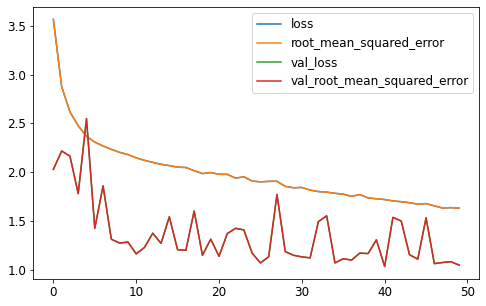

In [59]:
# print("Fit model on training data")
# history = model.fit(
#     x=train_dataset,
#     validation_data=validation_dataset,
#     epochs=100,
#     callbacks=callbacks,
#     use_multiprocessing=True,
#     workers=4
# )
print("Fit model on training data")
history = model.fit(
    X_train_preloaded,
    y_train_full,
    batch_size=32,
    epochs=50,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    # validation_data=(X_valid, y_valid),
    validation_split=0.2,
    shuffle=True,
    callbacks=callbacks
)
pd.DataFrame(history.history).plot(figsize=(8, 5))

# Tests

In [18]:
def filter_dataset(X, y, aug_type_list):
    '''
    filter dataset according to the augment type
    :param X: tuple (path,augment type)
    :param y: labels
    :param aug_type: the aug type to remain - list
    :return: the filtered X and y
    '''
    dataset_props = [(img_prop, label) for img_prop, label in zip(X, y) if img_prop[1] in aug_type_list]
    new_X = [k[0] for k in dataset_props]
    new_y = [k[1] for k in dataset_props]
    return new_X, new_y


def calculate_rmse(X, y, dataset_train, preprocess_img_method):
    X_test = preprocess(X, dataset_train, preprocess_img_method=preprocess_img_method)
    X_test = np.stack(X_test)
    y_test = copy.deepcopy(y)
    n = len(y_test)
    # predictions
    preds = model.predict(X_test)
    preds = [item for sublist in preds for item in sublist]
    preds = np.array(preds)
    # ground truth
    vals = np.array(y_test)
    # calc metric
    rmse = [np.sqrt(np.sum(np.square(preds - vals)) / n)]
    return rmse[0]

In [37]:
# TEST RMSE for best model
model = restore_model_weights_only()  # Restore Model

Restoring from ./ckpt/cc-2-vgg-r\val_loss=1.692_loss=2.373_rmse=1.692_ckpt=10


In [43]:
# Verify model Set
X_val_filtered, y_val_filtered = filter_dataset(X_val, y_val, [0])
rmse_val = calculate_rmse(X_val_filtered, y_val_filtered, dataset_train_path, preprocess_img)
print("model validation rmse: ", rmse_val)

loading data


100%|██████████| 2716/2716 [00:02<00:00, 1199.35it/s]


loading data done
Validation model rmse:  [1.6203694801615052]


In [36]:
# Test set
X_test_filtered, y_test_filtered = filter_dataset(X_test_full, y_test_full, aug_types)
rmse_val = calculate_rmse(X_test_filtered, y_test_filtered, dataset_train_path, preprocess_img)
print("model test rmse: ", rmse_val)

loading data


100%|██████████| 11250/11250 [00:14<00:00, 756.64it/s]


loading data done
model test rmse:  1.0428707551349807


In [35]:
print(rmse_val)

0.9942814092981027


In [ ]:
# Save Model

In [21]:
model.save('./ckpt/full_saves/3-complex-regression/', save_format='tf')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./ckpt/full_saves/3-complex-regression/assets


In [ ]:
model = tf.keras.models.load_model('./ckpt/full_saves/2-complex-regression/')

In [1]:
## TEST restore weights
# model = make_or_restore_model_weights_only_compiled()

In [29]:
# # Re-evaluate the model
# loss, rmse = model.evaluate(validation_dataset, verbose=2)
# print("Restored model, rmse: {:.5f}".format(rmse))

169/169 - 18s - loss: 1.5432 - root_mean_squared_error: 1.5431
Restored model, rmse: 1.54306


## Submission

In [22]:
# Submission
df_test = pd.read_csv(dataset_csv_test, delimiter='\ ', header=None)
print(df_test)

                                     0
0    /test/test_composite000000001.png
1    /test/test_composite000000000.png
2    /test/test_composite000000002.png
3    /test/test_composite000000003.png
4    /test/test_composite000000004.png
..                                 ...
495  /test/test_composite000000495.png
496  /test/test_composite000000496.png
497  /test/test_composite000000497.png
498  /test/test_composite000000498.png
499  /test/test_composite000000499.png

[500 rows x 1 columns]


C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [23]:
X_test_full = preprocess_test(df_test[0], dataset_test_path, preprocess_img_method=preprocess_img)
X_test_full = np.stack(X_test_full)

loading data


100%|██████████| 500/500 [00:00<00:00, 738.04it/s]

loading data done


In [24]:
#Predict
predictions = model.predict(X_test_full)
predictions = [item for sublist in predictions for item in sublist]
# predictions = [int(np.rint(pred)) for pred in preds]

In [25]:
print(predictions)

[22.964825, 23.199219, 12.196132, 26.013096, 24.421452, 12.2534685, 26.766933, 24.772411, 1.4831853, 8.469578, 18.622028, 2.6990542, 4.4918365, 22.277699, 17.233555, 5.4176226, 8.254222, 2.297769, 27.488556, 14.593267, 4.3616767, 19.115053, 24.344158, 13.649674, 14.346514, 0.30191517, 5.41485, 2.1801672, 9.411743, 2.357757, 8.848999, 24.202465, 12.110636, 19.82547, 26.895401, 0.35781527, 14.929427, 9.803818, 2.233667, 5.9381742, 15.040604, 17.886972, 5.056798, 26.136856, 15.172952, 21.41661, 15.946931, 27.253902, 2.4393451, 19.339157, 23.50853, 3.3449996, 22.637272, 7.287362, 1.246223, 24.707966, 4.979129, 13.409959, 20.280987, 28.046413, 21.613503, 21.003578, 20.012997, 2.82752, 4.690666, 13.09622, 0.4955945, 3.2955456, 9.246574, 12.147297, 21.58458, 1.2746458, 0.5189326, 9.881375, 29.384342, 8.705046, 8.472585, 14.398959, 12.353869, 26.390259, 6.4867334, 17.73642, 28.538898, 23.81583, 1.9313121, 20.54044, 25.295113, 27.228886, 23.159336, 21.349735, 20.577656, 21.77494, 30.505592, 2.9

In [26]:
indexes = []
for i in range(len(predictions)):
    indexes.append(i)

In [27]:
print(indexes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [28]:
import pandas

df = pandas.DataFrame(data={"index": indexes, "prediction": predictions})
df.to_csv("./sub-4-c-r.csv", sep=',', index=False)